In [1]:
'''Trains a simple convnet on the MNIST dataset.

Gets to 99.25% test accuracy after 28 epochs
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, Input, Concatenate
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import multi_gpu_model
from matplotlib import pyplot
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

batch_size = 128
num_classes = 10
epochs = 200

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# create a grid of 3x3 images
for i in range(0, 9):
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
    
# show the plot
pyplot.show()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7307013709747136391
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11987822183
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 10686322836204934166
physical_device_desc: "device: 0, name: GeForce GTX TITAN X, pci bus id: 0000:05:00.0, compute capability: 5.2"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 11987822183
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 15097088319365676168
physical_device_desc: "device: 1, name: GeForce GTX TITAN X, pci bus id: 0000:08:00.0, compute capability: 5.2"
]


<Figure size 640x480 with 9 Axes>

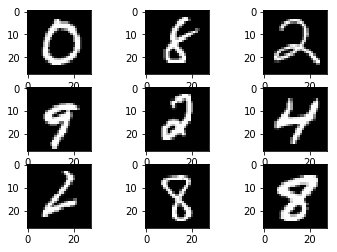

In [2]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    bn_axis = 1
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    bn_axis = 3

nb_train_samples = x_train.shape[0]
nb_test_samples = x_test.shape[0]

# define data preparation
train_datagen_rand = ImageDataGenerator(
    rescale=1. / 255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2 )

train_datagen = ImageDataGenerator( rescale=1. / 255. )

test_datagen = ImageDataGenerator(
    rescale = 1./255.)

# fit parameters from data
train_datagen.fit(x_train)
test_datagen.fit(x_test)
# configure batch size and retrieve one batch of images
for x_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(x_batch[i].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()
    break
    

In [3]:
batch_size = 128
epochs = 30
num_gpu = 2

# convert class vectors to binary class matrices
y_train_onehot = keras.utils.to_categorical(y_train, num_classes)
x_test_norm = x_test/255.
y_test_onehot = keras.utils.to_categorical(y_test, num_classes)

train_generator = train_datagen.flow(
    x_train, y_train_onehot, 
    batch_size=batch_size)

validation_generator = test_datagen.flow(
    x_test, y_test_onehot, 
    batch_size=batch_size,
    shuffle=False)

model_store = "/cpu:0"
with tf.device(model_store):
    img_input = Input(shape = input_shape)
    conv1 = Conv2D(32, kernel_size=(3, 3), padding = "same")(img_input)
    bn1 = BatchNormalization(axis=bn_axis)(conv1)
    act1 = Activation("relu")(bn1)
    conv2 = Conv2D(64, (3, 3), padding = "same")(act1)
    dense2 = Concatenate( axis=bn_axis)([conv2, conv1])
    bn2 = BatchNormalization(axis=bn_axis)(conv2)
    act2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act2)
    drop2 = Dropout(0.25)(pool2)
    flat2 = Flatten()(drop2)
    dense3 = Dense(128, activation='relu')(flat2)
    drop3 = Dropout(0.5)(dense3)
    output = Dense(num_classes, activation='softmax')(drop3)
    
    base_model = Model( inputs = img_input, outputs = output)
    

model = multi_gpu_model(base_model, gpus=num_gpu)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit_generator(train_generator,
                    steps_per_epoch=nb_train_samples // batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=validation_generator,
          validation_steps=nb_train_samples // batch_size,
                    initial_epoch = 0
         )


Epoch 1/30
468/468 [==============================] - 14s 30ms/step - loss: 0.5688 - acc: 0.8308 - val_loss: 0.0799 - val_acc: 0.9761
Epoch 2/30
468/468 [==============================] - 10s 21ms/step - loss: 0.1807 - acc: 0.9478 - val_loss: 0.0663 - val_acc: 0.9789
Epoch 3/30
468/468 [==============================] - 10s 21ms/step - loss: 0.1297 - acc: 0.9633 - val_loss: 0.0435 - val_acc: 0.9860
Epoch 4/30
468/468 [==============================] - 10s 21ms/step - loss: 0.1085 - acc: 0.9688 - val_loss: 0.0445 - val_acc: 0.9874
Epoch 5/30
468/468 [==============================] - 10s 21ms/step - loss: 0.0961 - acc: 0.9723 - val_loss: 0.0407 - val_acc: 0.9865
Epoch 6/30
468/468 [==============================] - 10s 21ms/step - loss: 0.0867 - acc: 0.9750 - val_loss: 0.0392 - val_acc: 0.9883
Epoch 7/30
468/468 [==============================] - 10s 21ms/step - loss: 0.0817 - acc: 0.9770 - val_loss: 0.0354 - val_acc: 0.9889
Epoch 8/30
468/468 [==============================] - 10s 21ms

In [4]:
score = model.evaluate_generator(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
res = model.predict_generator(validation_generator)

Test loss: 0.03779587302723144
Test accuracy: 0.9902


In [5]:
import numpy as np
tt = np.array([0]*10)
tf = np.array([0]*10)
ft = np.array([0]*10)
ff = np.array([0]*10)
pred= np.argmax(res,axis=1)
for i in range(len(y_test)):
    # print(str(pred[i])+"/"+str(validation_generator.classes[i]))
    for j in range(10):
        actc = str(j)
        if str(y_test[i])==actc:
            if str(pred[i]) == actc:
                tt[j]+=1
            else:
                tf[j]+=1
        else:
            if str(pred[i]) == actc:
                ft[j]+=1
            else:
                ff[j]+=1

In [6]:
from sklearn.metrics import *
print(pred )
cnf_matrix = confusion_matrix(y_test, pred)

[7 2 1 ... 4 5 6]


Normalized confusion matrix
[[9.94897959e-01 0.00000000e+00 2.04081633e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.02040816e-03 1.02040816e-03
  1.02040816e-03 0.00000000e+00]
 [0.00000000e+00 9.95594714e-01 1.76211454e-03 8.81057269e-04
  0.00000000e+00 8.81057269e-04 8.81057269e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.68992248e-04 0.00000000e+00 9.96124031e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.90697674e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.96039604e-03 9.93069307e-01
  0.00000000e+00 1.98019802e-03 0.00000000e+00 0.00000000e+00
  9.90099010e-04 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.92871690e-01 0.00000000e+00 4.07331976e-03 0.00000000e+00
  0.00000000e+00 3.05498982e-03]
 [3.36322870e-03 1.12107623e-03 0.00000000e+00 5.60538117e-03
  0.00000000e+00 9.86547085e-01 3.36322870e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.17536534e-03 2.08768267e-0

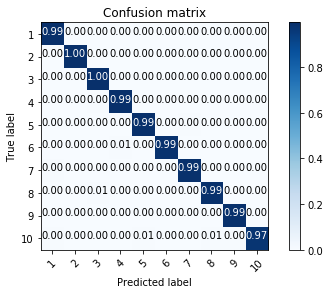

In [7]:
import sys
sys.path.append("../utils")
from confusion import *
plot_confusion_matrix(cnf_matrix, [str(i+1) for i in range(10)],normalize=True)